In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, InputLayer, Attention, InputLayer, Input, Flatten
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Reading the dataset
data_csv = "./dataset.csv"
df = pd.read_csv(data_csv)
print('Dataset shape: ', df.shape)
print(df.dtypes)
df.head()

Dataset shape:  (1089, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-31,1196.400024,1212.400024,1182.000000,1201.900024,1201.900024,124.0
1,2014-01-02,1204.300049,1227.300049,1204.300049,1225.000000,1225.000000,209.0
2,2014-01-03,1221.699951,1239.000000,1221.699951,1238.400024,1238.400024,142.0
3,2014-01-06,1232.800049,1247.000000,1221.900024,1237.800049,1237.800049,127.0
4,2014-01-07,1239.300049,1242.400024,1226.300049,1229.400024,1229.400024,73.0


In [3]:
# Verifying null values and deleting name from dataset
null_columns = df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())
# Drop the lines with null values
df = df.dropna()

     Open  High  Low  Close  Adj Close  Volume
127   NaN   NaN  NaN    NaN        NaN     NaN
230   NaN   NaN  NaN    NaN        NaN     NaN
248   NaN   NaN  NaN    NaN        NaN     NaN
515   NaN   NaN  NaN    NaN        NaN     NaN
535   NaN   NaN  NaN    NaN        NaN     NaN


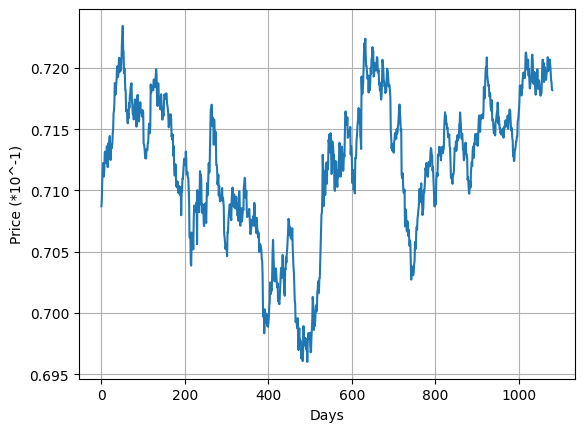

In [4]:
# Transforming the dataset to ln scale
df = np.log(df["Open"].values)

# Plot the data
plt.figure()
plt.plot(df/10)
plt.xlabel("Days")
plt.ylabel("Price (*10^-1)")
plt.grid()
plt.show()

In [5]:
timesteps = 7 
split_ratio = 0.8  

arima_data = df.copy() 
df_reshaped = df.reshape(-1, 1)  

features = []
target = []
for i in range(timesteps, len(df_reshaped)):
    features.append(df_reshaped[i - timesteps:i])
    target.append(df_reshaped[i])

features = np.array(features)
target = np.array(target)

split_index = int(len(features) * split_ratio)
train_features, test_features = features[:split_index], features[split_index:]
train_labels, test_labels = target[:split_index], target[split_index:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_features_scaled = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
test_features_scaled = scaler.transform(test_features.reshape(-1, test_features.shape[-1])).reshape(test_features.shape)
train_labels_scaled = scaler.fit_transform(train_labels)
test_labels_scaled = scaler.transform(test_labels)

train_arima = arima_data[:int(len(arima_data) * split_ratio)]
test_arima = arima_data[int(len(arima_data) * split_ratio):]

print("Train Features (LSTM/CNN): ", train_features_scaled.shape)
print("Test Features (LSTM/CNN): ", test_features_scaled.shape)
print("Train Labels (LSTM/CNN): ", train_labels_scaled.shape)
print("Test Labels (LSTM/CNN): ", test_labels_scaled.shape)
print("Train ARIMA: ", train_arima.shape)
print("Test ARIMA: ", test_arima.shape)


Train Features (LSTM/CNN):  (859, 7, 1)
Test Features (LSTM/CNN):  (215, 7, 1)
Train Labels (LSTM/CNN):  (859, 1)
Test Labels (LSTM/CNN):  (215, 1)
Train ARIMA:  (864,)
Test ARIMA:  (217,)


ARIMA Model Evaluation:
MAE: 0.03105009307128872
MSE: 0.0014014216632501988


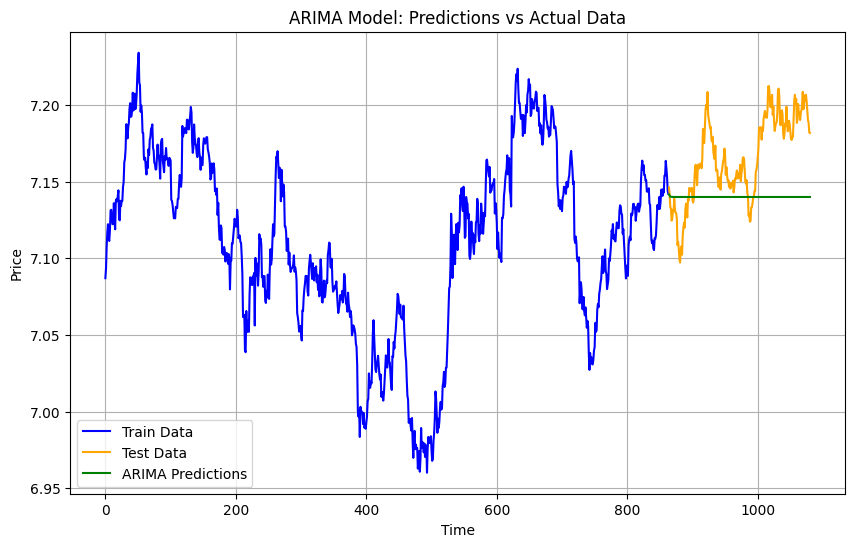

In [6]:
##############################
# ARIMA Model
##############################

arima_order = (5, 1, 0)

arima_model = ARIMA(train_arima, order=arima_order)
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=len(test_arima))

arima_mae = mean_absolute_error(test_arima, arima_predictions)
arima_mse = mean_squared_error(test_arima, arima_predictions)

print("ARIMA Model Evaluation:")
print(f"MAE: {arima_mae}")
print(f"MSE: {arima_mse}")


train_index = np.arange(len(train_arima))
test_index = np.arange(len(train_arima), len(train_arima) + len(test_arima))

plt.figure(figsize=(10, 6))
plt.plot(train_index, train_arima, color='blue', label='Train Data')
plt.plot(test_index, test_arima, color='orange', label='Test Data')
plt.plot(test_index, arima_predictions, color='green', label='ARIMA Predictions')

plt.title('ARIMA Model: Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

SVR Model Evaluation:
MAE: 0.0050556912203048865
MSE: 4.0876520287871014e-05


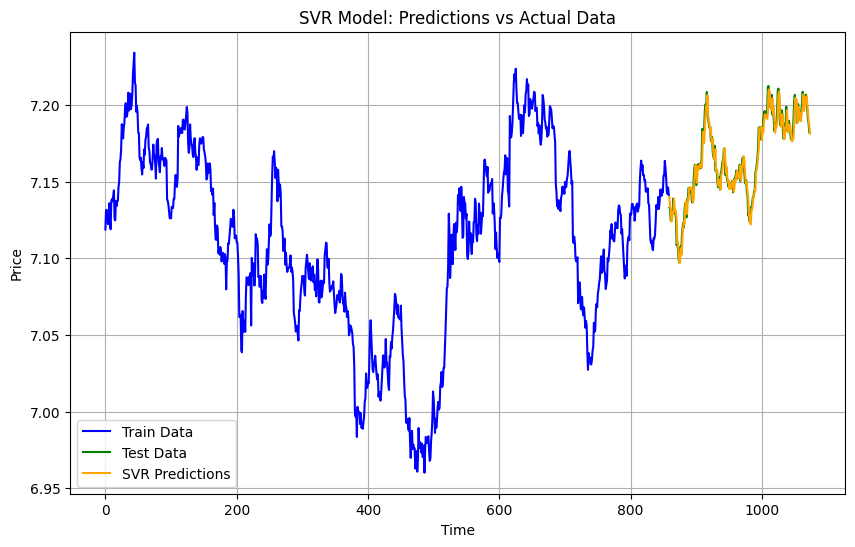

In [7]:
##############################
# SVR Model
##############################

svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svr_model.fit(train_features_scaled.reshape(train_features_scaled.shape[0], -1), train_labels_scaled.flatten())
svr_predictions = svr_model.predict(test_features_scaled.reshape(test_features_scaled.shape[0], -1))
svr_predictions_original = scaler.inverse_transform(svr_predictions.reshape(-1, 1)).flatten()
svr_mae = mean_absolute_error(test_labels, svr_predictions_original)
svr_mse = mean_squared_error(test_labels, svr_predictions_original)

print("SVR Model Evaluation:")
print(f"MAE: {svr_mae}")
print(f"MSE: {svr_mse}")

train_index = np.arange(len(train_labels))
test_index = np.arange(len(train_labels), len(train_labels) + len(test_labels))

# Plot predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(train_index, train_labels, color='blue', label='Train Data')
plt.plot(test_index, test_labels[:len(test_index)], color='green', label='Test Data')
plt.plot(test_index, svr_predictions_original, color='orange', label='SVR Predictions')

plt.title('SVR Model: Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1872
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoc

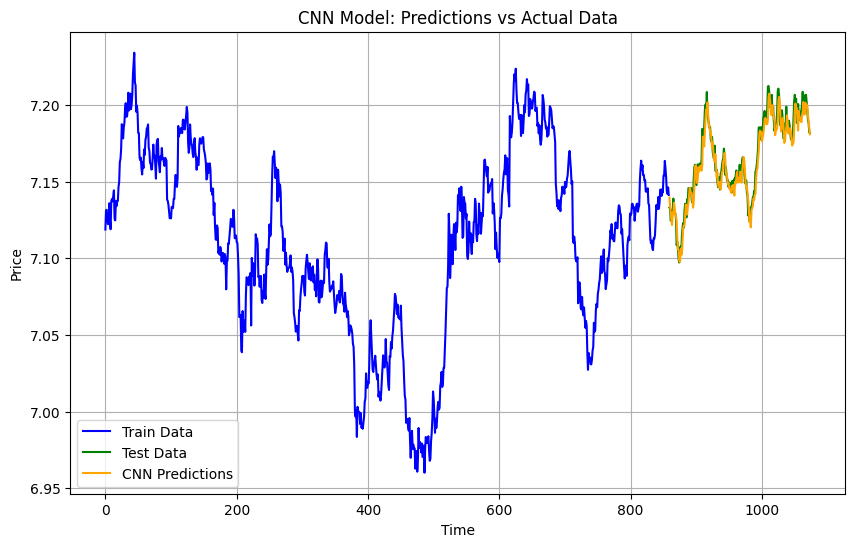

In [8]:
##############################
# CNN Model
##############################

model_cnn = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(train_features_scaled.shape[1], train_features_scaled.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_cnn.fit(train_features_scaled, train_labels_scaled, epochs=100, batch_size=32, verbose=1)
cnn_predictions = model_cnn.predict(test_features_scaled).flatten()
cnn_predictions_original = scaler.inverse_transform(cnn_predictions.reshape(-1, 1)).flatten()

cnn_mae = mean_absolute_error(test_labels, cnn_predictions_original)
cnn_mse = mean_squared_error(test_labels, cnn_predictions_original)

print("CNN Model Evaluation:")
print(f"MAE: {cnn_mae}")
print(f"MSE: {cnn_mse}")

train_index = np.arange(len(train_labels))
test_index = np.arange(len(train_labels), len(train_labels) + len(test_labels))

# Plot predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(train_index, train_labels, color='blue', label='Train Data')
plt.plot(test_index, test_labels[:len(test_index)], color='green', label='Test Data')
plt.plot(test_index, cnn_predictions_original, color='orange', label='CNN Predictions')

plt.title('CNN Model: Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/100


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2327
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 16/100
27/

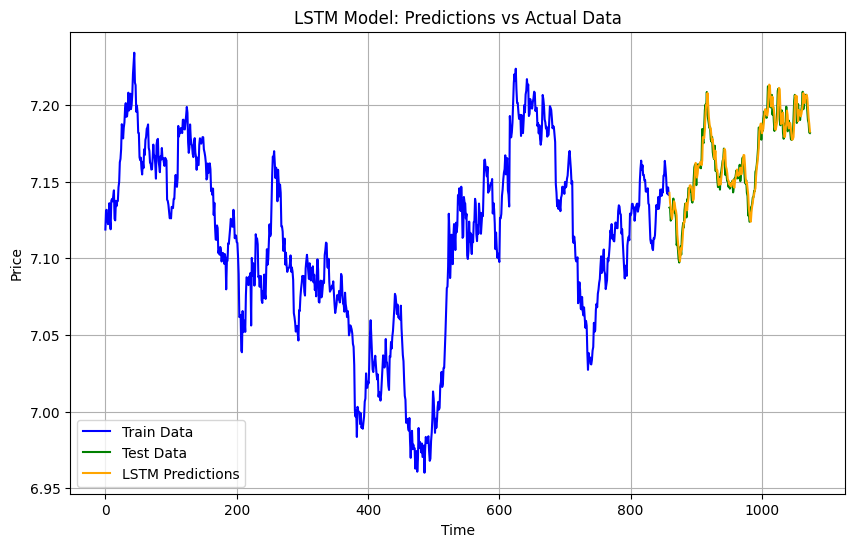

In [9]:
##############################
# LSTM Model
##############################
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(train_features_scaled.shape[1], train_features_scaled.shape[2])),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_lstm.fit(train_features_scaled, train_labels_scaled, epochs=100, batch_size=32, verbose=1)
lstm_predictions = model_lstm.predict(test_features_scaled).flatten()
lstm_predictions_original = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()

lstm_mae = mean_absolute_error(test_labels, lstm_predictions_original)
lstm_mse = mean_squared_error(test_labels, lstm_predictions_original)

print("LSTM Model Evaluation:")
print(f"MAE: {lstm_mae}")
print(f"MSE: {lstm_mse}")

train_index = np.arange(len(train_labels))
test_index = np.arange(len(train_labels), len(train_labels) + len(test_labels))

# Plot predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(train_index, train_labels, color='blue', label='Train Data')
plt.plot(test_index, test_labels[:len(test_index)], color='green', label='Test Data')
plt.plot(test_index, lstm_predictions_original, color='orange', label='LSTM Predictions')

plt.title('LSTM Model: Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2407
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 16/100
27

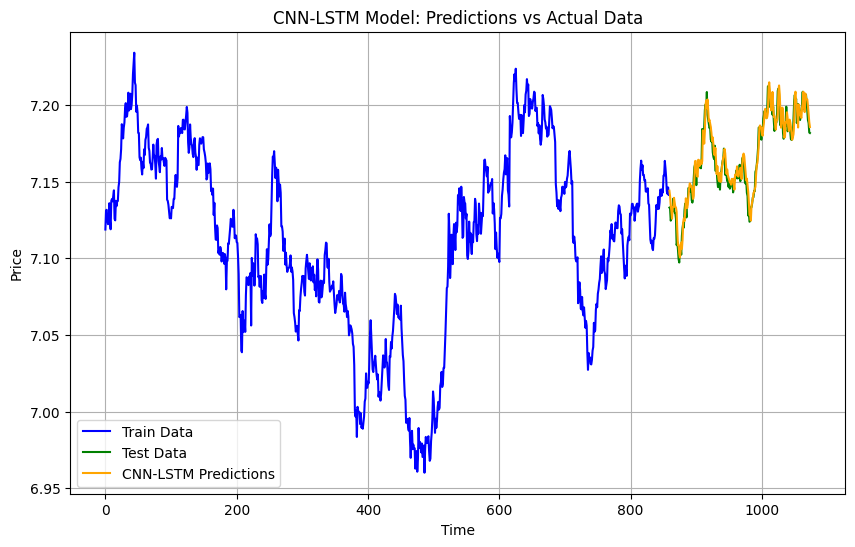

In [10]:
##############################
# CNN-LSTM Model
##############################
model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(train_features_scaled.shape[1], train_features_scaled.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dense(1)
])

model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_cnn_lstm.fit(train_features_scaled, train_labels_scaled, epochs=100, batch_size=32, verbose=1)
cnn_lstm_predictions = model_cnn_lstm.predict(test_features_scaled).flatten()
cnn_lstm_predictions_original = scaler.inverse_transform(cnn_lstm_predictions.reshape(-1, 1)).flatten()

cnn_lstm_mae = mean_absolute_error(test_labels, cnn_lstm_predictions_original)
cnn_lstm_mse = mean_squared_error(test_labels, cnn_lstm_predictions_original)

print("CNN-LSTM Model Evaluation:")
print(f"MAE: {cnn_lstm_mae}")
print(f"MSE: {cnn_lstm_mse}")

train_index = np.arange(len(train_labels))
test_index = np.arange(len(train_labels), len(train_labels) + len(test_labels))

# Plot predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(train_index, train_labels, color='blue', label='Train Data')
plt.plot(test_index, test_labels[:len(test_index)], color='green', label='Test Data')
plt.plot(test_index, cnn_lstm_predictions_original, color='orange', label='CNN-LSTM Predictions')

plt.title('CNN-LSTM Model: Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2031
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029
Epoch 16/100

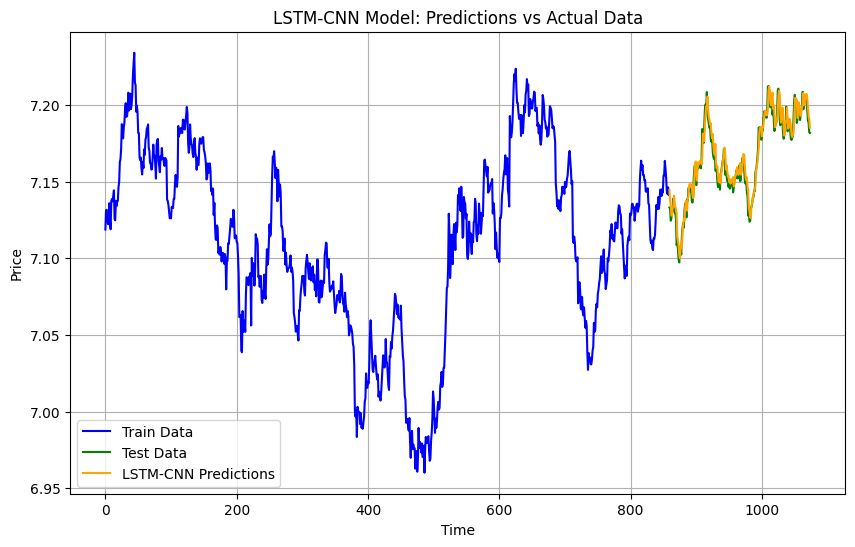

In [11]:
##############################
# LSTM-CNN Model
##############################
model_lstm_cnn = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(train_features_scaled.shape[1], train_features_scaled.shape[2])),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1)
])

model_lstm_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_lstm_cnn.fit(train_features_scaled, train_labels_scaled, epochs=100, batch_size=32, verbose=1)
lstm_cnn_predictions = model_lstm_cnn.predict(test_features_scaled).flatten()
lstm_cnn_predictions_original = scaler.inverse_transform(lstm_cnn_predictions.reshape(-1, 1)).flatten()

lstm_cnn_mae = mean_absolute_error(test_labels, lstm_cnn_predictions_original)
lstm_cnn_mse = mean_squared_error(test_labels, lstm_cnn_predictions_original)

print("LSTM-CNN Model Evaluation:")
print(f"MAE: {lstm_cnn_mae}")
print(f"MSE: {lstm_cnn_mse}")

train_index = np.arange(len(train_labels))
test_index = np.arange(len(train_labels), len(train_labels) + len(test_labels))

# Plot predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(train_index, train_labels, color='blue', label='Train Data')
plt.plot(test_index, test_labels[:len(test_index)], color='green', label='Test Data')
plt.plot(test_index, lstm_cnn_predictions_original, color='orange', label='LSTM-CNN Predictions')

plt.title('LSTM-CNN Model: Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1663
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0116
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.

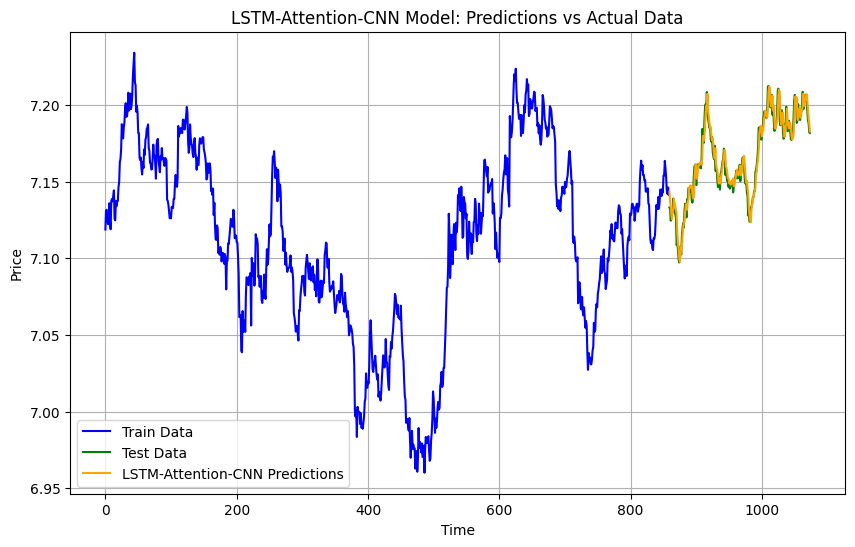

In [12]:
##############################
# LSTM-Attention-CNN Model
##############################

input_layer = tf.keras.Input(shape=(train_features_scaled.shape[1], train_features_scaled.shape[2]))
lstm_layer = LSTM(50, activation='relu', return_sequences=True)(input_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
cnn_layer = Conv1D(64, kernel_size=2, activation='relu')(attention_layer)
maxpool_layer = MaxPooling1D(pool_size=2)(cnn_layer)
flatten_layer = Flatten()(maxpool_layer)
output_layer = Dense(1)(flatten_layer)

model_lstm_attention_cnn = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_lstm_attention_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_lstm_attention_cnn.fit(train_features_scaled, train_labels_scaled, epochs=100, batch_size=32, verbose=1)
lstm_attention_cnn_predictions = model_lstm_attention_cnn.predict(test_features_scaled).flatten()
lstm_attention_cnn_predictions_original = scaler.inverse_transform(lstm_attention_cnn_predictions.reshape(-1, 1)).flatten()

lstm_attention_cnn_mae = mean_absolute_error(test_labels, lstm_attention_cnn_predictions_original)
lstm_attention_cnn_mse = mean_squared_error(test_labels, lstm_attention_cnn_predictions_original)

print("LSTM-Attention-CNN Model Evaluation:")
print(f"MAE: {lstm_attention_cnn_mae}")
print(f"MSE: {lstm_attention_cnn_mse}")

train_index = np.arange(len(train_labels))
test_index = np.arange(len(train_labels), len(train_labels) + len(test_labels))

# Plot predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(train_index, train_labels, color='blue', label='Train Data')
plt.plot(test_index, test_labels[:len(test_index)], color='green', label='Test Data')
plt.plot(test_index, lstm_attention_cnn_predictions_original, color='orange', label='LSTM-Attention-CNN Predictions')

plt.title('LSTM-Attention-CNN Model: Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
models = [arima_model, model_cnn, model_lstm, svr_model, model_cnn_lstm, model_lstm_cnn, model_lstm_attention_cnn]
labels = ['ARIMA', 'CNN', 'LSTM', 'SVR', 'CNN-LSTM', 'LSTM-CNN', 'LSTM-Attention-CNN']

model_list = []
MAE_list = [arima_mae, cnn_mae, lstm_mae, svr_mae, cnn_lstm_mae, lstm_cnn_mae, lstm_attention_cnn_mae]
MSE_list = [arima_mse, cnn_mse, lstm_mse, svr_mse, cnn_lstm_mse, lstm_cnn_mse, lstm_attention_cnn_mse]

index_model = 0
for i in range(index_model, index_model + len(models)):

    model_list.append(labels[i])
    MAE_list.append(MAE_list[i])
    MSE_list.append(MSE_list[i])

df_print = pd.DataFrame(list(zip(model_list, MAE_list, MSE_list)),
                        columns=['Model', 'MAE', 'MSE'])

display(df_print)

index_model += len(models)

,Model,MAE,MSE
0,ARIMA,0.031050,0.001401
1,CNN,0.005676,0.000051
2,LSTM,0.005403,0.000046
3,SVR,0.005056,0.000041
4,CNN-LSTM,0.005646,0.000049
5,LSTM-CNN,0.005230,0.000044
6,LSTM-Attention-CNN,0.005222,0.000044
